In [1]:
# Import Python Libraries
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter, NullFormatter

In [2]:
np.seterr(divide='ignore')
np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# Load Bitcoin Price Data
df = pd.read_csv('../../github-bitcoin-scripts/bitcoin-data/bitcoin-daily-data.csv')
orig_dates = df['date'].to_list()
orig_dates[-1]

'2/12/22'

In [4]:
# Date Conversion Functions
def str_to_datetime(strs):
    """Convert a list of "YYYY-MM-DD" strings to datetime objects."""
    dates = []
    for date in strs:
        if '-' in date:
            y, m, d = (int(x) for x in date.split("-"))
        elif '/' in date:
            m, d, y = int(date.split('/')[0]), int(date.split('/')[1]), \
                      int(date.split('/')[2])+2000
        date = datetime(y, m, d)
        dates.append(date)
    return dates

def x_axis_dates(ax=None, fig=None):
    """Helper function to format the x axis as dates.

    Input:
    ax:  An Axes instance or an iterable of Axes instances.
    Optional, defaults to plt.gca()
    fig: The Figure instance containing those Axes or Axeses
    Optional, defaults to plt.gcf()
    """
    if ax is None: ax = plt.gca()
    if fig is None: fig = plt.gcf()
    loc = mdates.AutoDateLocator()
    fmt = mdates.AutoDateFormatter(loc)
    try:
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(fmt)
    except AttributeError:
        for a in ax:
            # Fresh locators/formatters are needed for each instance
            loc = mdates.AutoDateLocator()
            fmt = mdates.AutoDateFormatter(loc)
            a.xaxis.set_major_locator(loc)
            a.xaxis.set_major_formatter(fmt)
    fig.autofmt_xdate()

datetimes = str_to_datetime(orig_dates)
dates = [mdates.date2num(date) for date in datetimes]

<Figure size 432x288 with 0 Axes>

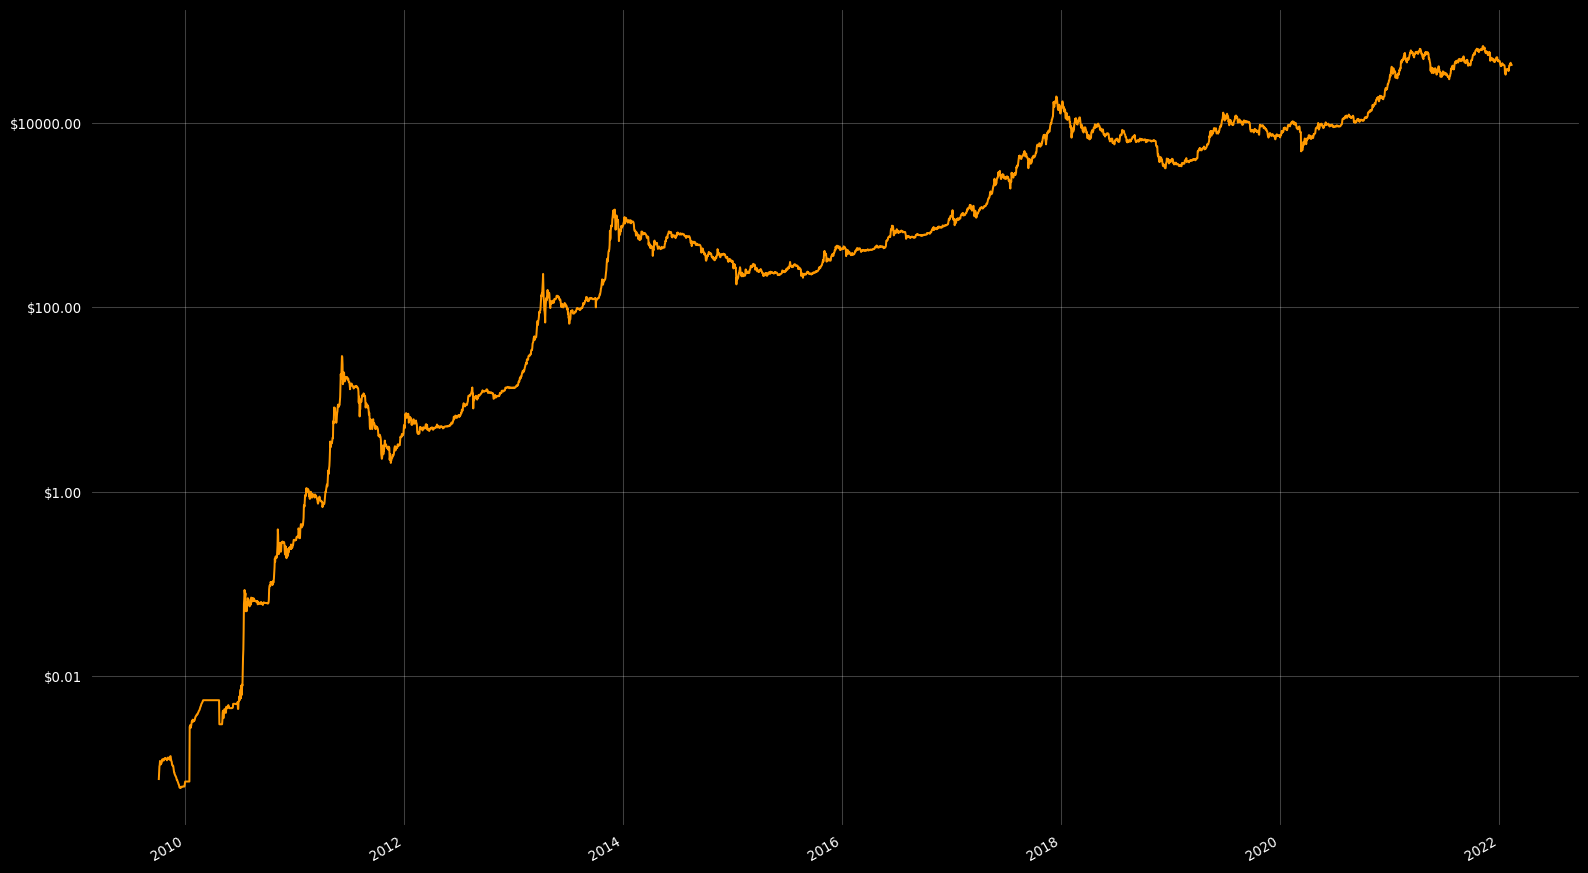

In [5]:
# Plot Bitcoin Daily Price Data (Sanity Check)
prices = df['price'].to_list()
first_price = np.where(np.array(prices) > 0)[0][0]
nonzero_prices = prices[first_price:]
nonzero_dates = dates[first_price:]

plt.clf()
scaling = 1.0
res = (1920/scaling, 1200/scaling)
size = res[0]/96.
size_y = res[1]/96.

fig = plt.subplots(figsize=(size, size_y), dpi=96, facecolor='black')
ax = plt.gca()
ax.set_facecolor("black")
ax = plt.gca()
ax.set_facecolor("black")
plt.plot(nonzero_dates, nonzero_prices, color='#ff9900')
plt.yscale('log')
plt.yticks(color='w')
plt.xticks(color='w')
plt.grid(color='w', alpha=0.25)
x_axis_dates()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:.2f}'))
ax.yaxis.set_minor_formatter(NullFormatter())

<Figure size 432x288 with 0 Axes>

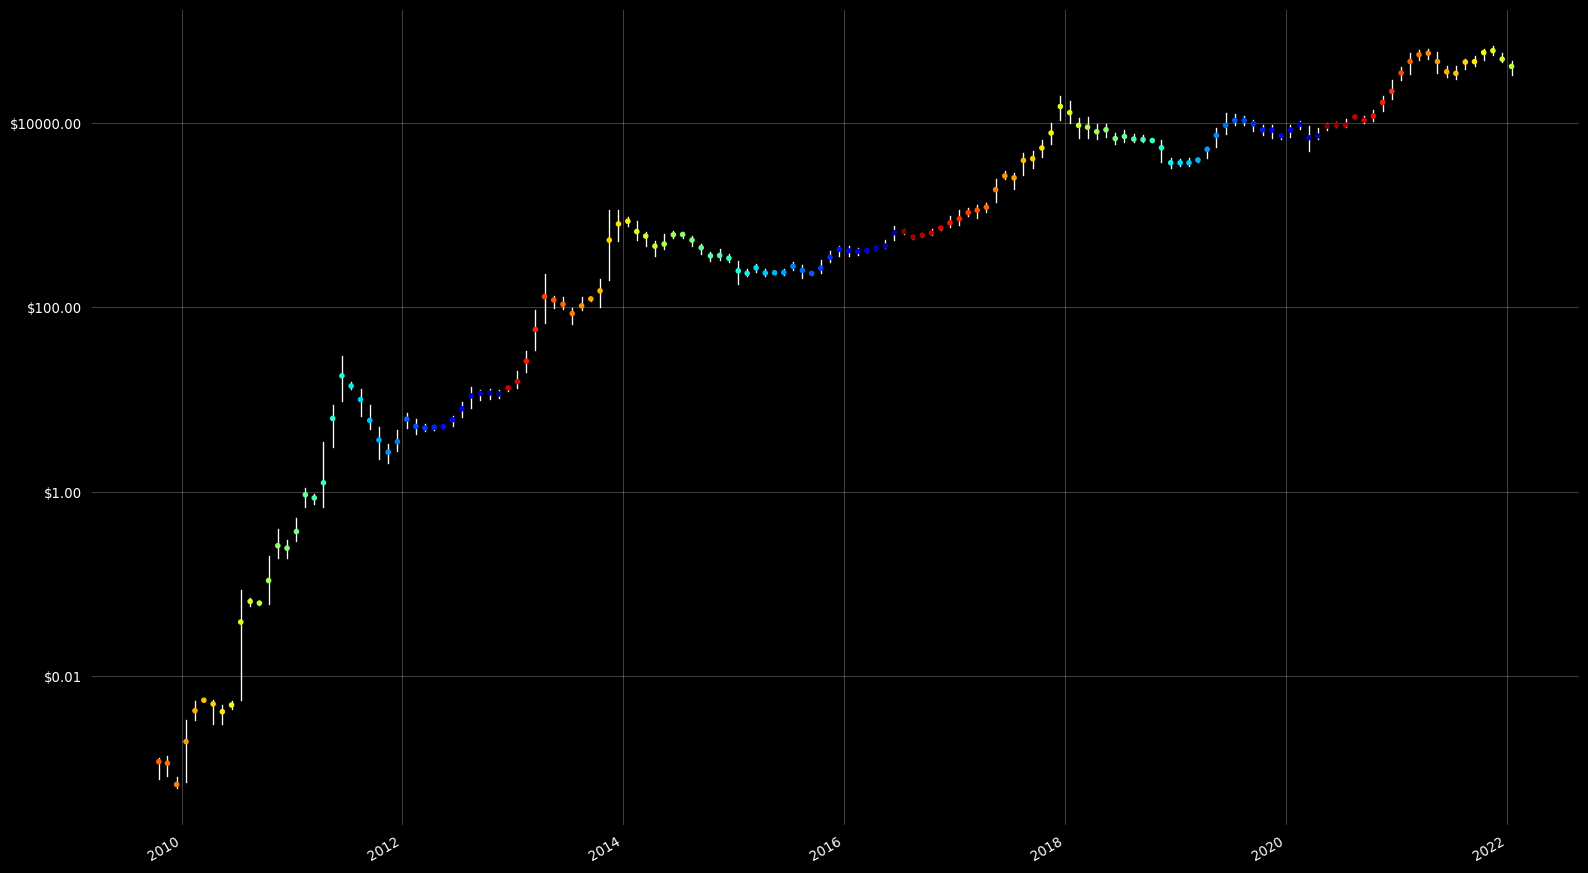

In [6]:
# Group Price Data by Month
# Dates given in days since 1/1/1970
halving_dates = [(datetime(2012, 11, 28) - datetime(1970, 1, 1)).days,
                 (datetime(2016, 7, 9) - datetime(1970, 1, 1)).days,
                 (datetime(2020, 5, 11) - datetime(1970, 1, 1)).days,
                 (datetime(2024, 3, 26) - datetime(1970, 1, 1)).days]

zero_ind = len(df[df['price'] == 0])
xdata = [int(date) for date in dates[zero_ind:]]
ydata = list(df['price'][df['price'] > 0])

monthly_dates = []
for y in range(2009, 2023):
    for m in range(12):
        monthly_dates.append((datetime(y, m+1, 1) - datetime(1970, 1, 1)).days)
    
min_m_price = []
max_m_price = []
avg_m_price = []
plot_dates = []
days_until_next_halving = []
months_until_next_halving = []
h = 0
for m in range(len(monthly_dates)-1):
    if (monthly_dates[m] in xdata) & (monthly_dates[m+1] in xdata):
        min_m_price.append(np.min(ydata[xdata.index(monthly_dates[m]):
                                        xdata.index(monthly_dates[m+1])]))
        max_m_price.append(np.max(ydata[xdata.index(monthly_dates[m]):
                                        xdata.index(monthly_dates[m+1])]))
        avg_m_price.append(np.mean(ydata[xdata.index(monthly_dates[m]):
                                         xdata.index(monthly_dates[m+1])]))
        plot_dates.append(np.mean(xdata[xdata.index(monthly_dates[m]):
                                        xdata.index(monthly_dates[m+1])]))
        while halving_dates[h] < plot_dates[-1]:
            h += 1
        days_until_next_halving.append(halving_dates[h] - plot_dates[-1])
        months_until_next_halving.append((halving_dates[h] - plot_dates[-1])/365.25*12)
    elif monthly_dates[m+1] in xdata:
        min_m_price.append(np.min(ydata[:xdata.index(monthly_dates[m+1])]))
        max_m_price.append(np.max(ydata[:xdata.index(monthly_dates[m+1])]))
        avg_m_price.append(np.mean(ydata[:xdata.index(monthly_dates[m+1])]))
        plot_dates.append(np.mean(xdata[:xdata.index(monthly_dates[m+1])]))
        while halving_dates[h] < plot_dates[-1]:
            h += 1
        days_until_next_halving.append(halving_dates[h] - plot_dates[-1])
        months_until_next_halving.append((halving_dates[h] - plot_dates[-1])/365.25*12)

plt.clf()
scaling = 1.0
res = (1920/scaling, 1200/scaling)
size = res[0]/96.
size_y = res[1]/96.

plt.rcParams['axes.titley'] = 1.01
# create figure and axis objects with subplots()
fig = plt.subplots(figsize=(size, size_y), dpi=96, facecolor='black')
ax = plt.gca()
ax.set_facecolor("black")
plt.scatter(plot_dates, avg_m_price, c=days_until_next_halving, cmap='jet', vmin=0, vmax=1400,
            s=10, zorder=2)
for p in range(len(min_m_price)):
    plt.plot([plot_dates[p], plot_dates[p]], [min_m_price[p], max_m_price[p]], lw=1, c='w',
             zorder=1)
plt.yscale('log')
plt.yticks(color='w')
plt.xticks(color='w')
plt.grid(color='w', alpha=0.25)
x_axis_dates()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:.2f}'))
ax.yaxis.set_minor_formatter(NullFormatter())

In [7]:
# original 4-parameter formulation
def stock2fomo(x0, y0, a, b, xfit=None, ymin=0.0001, ymax=10**12):
    if xfit is None:
        xfit = list(range(int(np.ceil(x0-1/b)), int(np.ceil(x0+1/b))))
    yfit = list(np.exp(a*np.log((1+b*(np.array(xfit)-x0))/(1-b*(np.array(xfit)-x0)))+y0))
    return xfit, yfit


# 3-parameter formulation (used if starting date is known: Oct 5, 2009)
def stock2fomo_v2(x0, y0, a, xfit=None, ymin=0.0001, ymax=10**12):
    if xfit is None:
        xfit = list(range(0, 2*x0))
    yfit = list(y0*(np.array(xfit)/(2*x0-np.array(xfit)))**a)
    return xfit, yfit


# calculate least squares residual and counts of data points over/under the predicted model price
def leastsqrs_res(ydata, yfit, count_start_month=24):
    res = 0
    over_count = 0
    under_count = 0
    for yd in range(len(ydata)):
        if yd >= count_start_month:
            if yfit[yd] > ydata[yd]:
                under_count += 1
            else:
                over_count += 1
        res += (ydata[yd] - yfit[yd])**2
    res = res/len(ydata)
    return res, over_count, under_count


def mk_s2fomo_df(s2fomo_df, xdata, ydata, x0_r, y0_r, a_r, b_r):
    starting_len = len(xdata)
    for x0 in x0_r:
        x0_2 = int(round(x0, 0))
        for a in a_r:
            a_2 = round(a, 2)
            for y0 in y0_r:
                y0_2 = round(y0, 2)
                b_continue = True
                prev_res = 0
                for b in b_r:
                    b_2 = round(b, 6)
                    if len(s2fomo_df[(s2fomo_df['x0'] == x0_2) & (s2fomo_df['y0'] == y0_2) &
                                     (s2fomo_df['a'] == a_2) & (s2fomo_df['b'] == b_2)]) == 0:
                        xfit = []
                        for x_d in xdata:
                            if (x_d > np.ceil(x0_2-1/b_2)) & (x_d < np.ceil(x0_2+1/b_2)):
                                xfit.append(x_d)
                        xfit, yfit = stock2fomo(x0_2, y0_2, a_2, b_2, xfit,
                                                ymin=np.exp(min(ydata))*0.1)
                        if xdata[0] > xfit[0]:
                            start_ind = xfit.index(xdata[0])
                            xfit = xfit[start_ind:]
                            yfit = yfit[start_ind:]
                        elif xdata[0] < xfit[0]:
                            start_ind = xdata.index(xfit[0])
                            xdata = xdata[start_ind:]
                            ydata = ydata[start_ind:]
                        if len(xdata) < len(xfit):
                            xfit = xfit[:len(xdata)]
                            yfit = yfit[:len(xdata)]
                        elif len(xdata) > len(xfit):
                            xdata = xdata[:len(xfit)]
                            ydata = ydata[:len(xfit)]
                        res, over_count, under_count = leastsqrs_res(np.log(ydata), np.log(yfit))
                        row = pd.DataFrame([[x0_2, y0_2, a_2, b_2, res, over_count, under_count]],
                                           columns=['x0', 'y0', 'a', 'b', 'res', 'over_count',
                                                    'under_count'])
                        s2fomo_df = s2fomo_df.append(row, ignore_index=True)
    return s2fomo_df


def stock2fomochart(x0, y0, a, b, s2f_alpha=1):
    plt.clf()
    scaling = 1.0
    res = (1920/scaling, 1680/scaling)
    size = res[0]/96.
    size_y = res[1]/96.
    plt.rcParams['axes.titley'] = 1.01
    # create figure and axis objects with subplots()
    fig = plt.subplots(figsize=(size, size_y), dpi=96, facecolor='black')
    ax = plt.axes()
    ax.set_facecolor("black")
    for spine in ax.spines.values():
            spine.set_edgecolor('white')
    for i in range(len(x0)):
        xfit, yfit = stock2fomo(x0[i], y0[i], a[i], b[i])
        plt.plot(xfit, yfit, color="white", linewidth=4/scaling, zorder=1, alpha=s2f_alpha)
        if i == 0:
            plt.plot([int(np.ceil(x0[i]+1/b[i])), int(np.ceil(x0[i]+1/b[i]))], [0, 10**15],
                     color='white', ls='--', linewidth=3/scaling, dashes=(6/scaling, 4/scaling))
            plt.plot([int(np.ceil(x0[i]-1/b[i])), int(np.ceil(x0[i]-1/b[i]))], [0, 10**15],
                     color='white', ls='--', linewidth=3/scaling, dashes=(6/scaling, 4/scaling))

    plt.scatter(plot_dates, avg_m_price, c=months_until_next_halving, cmap='jet',
                s=50/scaling, vmin=0, vmax=48, zorder=3)
    
    plt.plot([nonzero_dates[0]-1]+nonzero_dates, [0]+nonzero_prices, c='w', zorder=2, lw=1)

    xticks_pos = [13879.0, 14609.0, 15339.0, 16070.0, 16800.0, 17531.0, 18261.0, 18992.0,
                  19722.0, 20453.0, 21183.0, 21914.0, 22644.0, 23375.0, 24105.0, 24836.0,
                  25566.0, 26297.0, 27027.0, 27758.0, 28488.0, 29219.0, 29950.0, 30681.0,
                  31411.0, 32142.0, 32872.0, 33603.0, 34333.0, 35064.0, 35794.0, 36525.0,
                  37255.0, 37986.0, 38716.0, 39447.0, 40177.0]
    xticks_labels = ["2008", "2010", "2012", "2014", "2016", "2018", "2020", "2022", "2024",
                     "2026", "2028", "2030", "2032", "2034", "2036", "2038", "2040", "2042",
                     "2044", "2046", "2048", "2050", "2052", "2054", "2056", "2058", "2060",
                     "2062", "2064", "2066", "2068", "2070", "2072", "2074", "2076", "2078",
                     "2080"]
    xt_pos = []
    xt_lab = []
    x_ind = 0
    while (xticks_pos[x_ind] < xfit[-1]) & (x_ind < (len(xticks_pos)-1)):
        if xfit[-1] > 29219:
            x_ind += 1
            xt_pos.append(xticks_pos[x_ind])
            xt_lab.append(xticks_labels[x_ind])
            if x_ind < (len(xticks_pos)-2):
                x_ind += 2
            elif x_ind < (len(xticks_pos)-1):
                x_ind += 1
        else:
            if x_ind != 0:
                xt_pos.append(xticks_pos[x_ind])
                xt_lab.append(xticks_labels[x_ind])
            x_ind += 1
    if x_ind < len(xticks_pos):
        if xfit[-1] < 25566:
            xt_pos.append(xticks_pos[x_ind])
            xt_lab.append(xticks_labels[x_ind])
    plt.yticks(fontsize=28/scaling, color='white')
    plt.xticks(xt_pos, xt_lab, fontsize=28/scaling, color='white')
    plt.xticks(rotation=45, ha="right")

    plt.yscale('log')
    plt.ylim(0.0001, 10**12)

    plt.yticks([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000,
                1000000000, 10000000000, 100000000000],
               ["0.1¢", "1¢", "10¢", "$1", "$10", "$100", "$1k", "$10k", "$100k", "$1M", "$10M",
                "$100M", "$1B", "$10B", "$100B"], fontsize=28/scaling, color='white')    
    
    cbar = plt.colorbar(aspect=50, pad=0.05, orientation="vertical", shrink=0.5,
                        ticks=[0, 12, 24, 36, 48])
    cbar.set_label('Months Until Next Halving', color='white', size=20/scaling, labelpad=20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white', fontsize=24/scaling)
        
    plt.grid(alpha=0.35, axis='both', color='white', linewidth=1/scaling)
    plt.ylabel('Price (USD)', fontsize=30/scaling, color='white', labelpad=20)
    plt.title(r'Bitcoin Stock2FOMO Hyperbolic Model',
              color='w', fontsize=32/scaling, pad=10)
    plt.show()
    
    
def stock2fomochart_v2(x0, y0, a, s2f_alpha=1):
    plt.clf()
    scaling = 1.0
    res = (1920/scaling, 1440/scaling)
    size = res[0]/96.
    size_y = res[1]/96.
    plt.rcParams['axes.titley'] = 1.01
    # create figure and axis objects with subplots()
    fig = plt.subplots(figsize=(size, size_y), dpi=96, facecolor='black')
    ax = plt.axes()
    ax.set_facecolor("black")
    for spine in ax.spines.values():
            spine.set_edgecolor('white')
    for i in range(len(x0)):
        xfit, yfit = stock2fomo_v2(x0[i], y0[i], a[i])
        plt.plot(xfit, yfit, color="white", linewidth=4/scaling, zorder=1, alpha=s2f_alpha)
        if i == 0:
            plt.plot([0, 0], [0, 10**15],
                     color='white', ls='--', linewidth=3/scaling, dashes=(6/scaling, 4/scaling))
            plt.plot([2*x0[0], 2*x0[0]], [0, 10**15],
                     color='white', ls='--', linewidth=3/scaling, dashes=(6/scaling, 4/scaling))

    plt.scatter([d-nonzero_dates[0] for d in plot_dates], avg_m_price, c=months_until_next_halving,
                cmap='jet', s=50/scaling, vmin=0, vmax=48, zorder=3)
    
    plt.plot([d-nonzero_dates[0] for d in [nonzero_dates[0]-1]+nonzero_dates],
             [0]+nonzero_prices, c='w', zorder=2, lw=1)

    plt.yticks(fontsize=28/scaling, color='white')
    plt.xticks(fontsize=28/scaling, color='white')
    plt.xticks(rotation=45, ha="right")

    plt.yscale('log')
    plt.ylim(0.0001, 10**12)

    plt.yticks([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000,
                1000000000, 10000000000, 100000000000],
               ["0.1¢", "1¢", "10¢", "$1", "$10", "$100", "$1k", "$10k", "$100k", "$1M", "$10M",
                "$100M", "$1B", "$10B", "$100B"], fontsize=28/scaling, color='white')    
    
    cbar = plt.colorbar(aspect=50, pad=0.05, orientation="vertical", shrink=0.5,
                        ticks=[0, 12, 24, 36, 48])
    cbar.set_label('Months Until Next Halving', color='white', size=20/scaling, labelpad=20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white', fontsize=24/scaling)
        
    plt.grid(alpha=0.35, axis='both', color='white', linewidth=1/scaling)
    plt.ylabel('Price (USD)', fontsize=30/scaling, color='white', labelpad=20)
    plt.title(r'Bitcoin Stock2FOMO Hyperbolic Model',
              color='w', fontsize=32/scaling, pad=10)
    plt.show()
    

def stock2fomochart_res(x0, y0, a, b):
    plt.clf()
    scaling = 1.0
    res = (1920/scaling, 480/scaling)
    size = res[0]/96.
    size_y = res[1]/96.
    plt.rcParams['axes.titley'] = 1.01
    # create figure and axis objects with subplots()
    fig = plt.subplots(figsize=(size, size_y), dpi=96, facecolor='black')
    ax = plt.axes()
    ax.set_facecolor("black")
    for spine in ax.spines.values():
            spine.set_edgecolor('white')
    xfit, yfit = stock2fomo(x0, y0, a, b)
    plt.plot([xfit[0], xfit[-1]], [0, 0], zorder=1, c='w', lw=4)        
    
    xticks_pos = [13879.0, 14609.0, 15339.0, 16070.0, 16800.0, 17531.0, 18261.0, 18992.0,
                  19722.0, 20453.0, 21183.0, 21914.0, 22644.0, 23375.0, 24105.0, 24836.0,
                  25566.0, 26297.0, 27027.0, 27758.0, 28488.0, 29219.0, 29950.0, 30681.0,
                  31411.0, 32142.0, 32872.0, 33603.0, 34333.0, 35064.0, 35794.0, 36525.0,
                  37255.0, 37986.0, 38716.0, 39447.0, 40177.0]
    xticks_labels = ["2008", "2010", "2012", "2014", "2016", "2018", "2020", "2022", "2024",
                     "2026", "2028", "2030", "2032", "2034", "2036", "2038", "2040", "2042",
                     "2044", "2046", "2048", "2050", "2052", "2054", "2056", "2058", "2060",
                     "2062", "2064", "2066", "2068", "2070", "2072", "2074", "2076", "2078",
                     "2080"]
    xt_pos = []
    xt_lab = []
    x_ind = 0
    while (xticks_pos[x_ind] < xfit[-1]) & (x_ind < (len(xticks_pos)-1)):
        if xfit[-1] > 29219:
            x_ind += 1
            xt_pos.append(xticks_pos[x_ind])
            xt_lab.append(xticks_labels[x_ind])
            if x_ind < (len(xticks_pos)-2):
                x_ind += 2
            elif x_ind < (len(xticks_pos)-1):
                x_ind += 1
        else:
            if x_ind != 0:
                xt_pos.append(xticks_pos[x_ind])
                xt_lab.append(xticks_labels[x_ind])
            x_ind += 1
    if x_ind < len(xticks_pos):
        if xfit[-1] < 25566:
            xt_pos.append(xticks_pos[x_ind])
            xt_lab.append(xticks_labels[x_ind])
    plt.yticks(fontsize=28/scaling, color='white')
    plt.xticks(xt_pos, xt_lab, fontsize=28/scaling, color='white')
    plt.xticks(rotation=45, ha="right")

    xfit, yfit = stock2fomo(x0, y0, a, b, xfit=nonzero_dates)
    plt.plot(nonzero_dates, [np.log10(nonzero_prices[p]/yfit[p])
                             for p in range(len(yfit))], c='w', zorder=2, lw=1)
    plt.plot([int(np.ceil(x0+1/b)), int(np.ceil(x0+1/b))], [-100, 100],
             color='white', ls='--', linewidth=3/scaling, dashes=(6/scaling, 4/scaling))
    plt.plot([int(np.ceil(x0-1/b)), int(np.ceil(x0-1/b))], [-100, 100],
             color='white', ls='--', linewidth=3/scaling, dashes=(6/scaling, 4/scaling))
    
    xfit = []
    skip = 1
    for x_d in plot_dates:
        if (x_d > np.ceil(x0-1/b)) & (x_d < np.ceil(x0+1/b)):
            xfit.append(x_d)
    xfit, yfit = stock2fomo(x0, y0, a, b, xfit=xfit)
    plt.scatter(plot_dates[skip:], [np.log10(avg_m_price[p+skip]/yfit[p+skip])
                                    for p in range(len(yfit)-skip)],
                c=months_until_next_halving[skip:], cmap='jet',
                s=50/scaling, vmin=0, vmax=48, zorder=3)
    
    plt.yticks(fontsize=28/scaling, color='white')
    plt.xticks(xt_pos, xt_lab, fontsize=28/scaling, color='white')
    plt.xticks(rotation=45, ha="right")
    
    cbar = plt.colorbar(aspect=50, orientation="vertical", ticks=[0, 12, 24, 36, 48])
    cbar.set_label('Months Until Next Halving', color='white', size=20/scaling, labelpad=20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white', fontsize=24/scaling)
        
    plt.grid(alpha=0.35, axis='both', color='white', linewidth=1/scaling)
    plt.ylim(-1.25, 2.25)
    plt.ylabel('log(Price / Model)', fontsize=30/scaling, color='white', labelpad=20)
#     plt.title(r'Bitcoin Hyperbolic Model (Stock2FOMO)', color='white', fontsize=32/scaling)
    plt.show()

In [8]:
s2fomo_df = pd.DataFrame(columns=['x0', 'y0', 'a', 'b', 'res', 'over_count', 'under_count'])

In [9]:
# loop through given ranges of parameters to check the fit of each combination
xdata = [int(date) for date in plot_dates]
ydata = list(avg_m_price)
b_interval = 0.000005
params = [
    {
        "x0_range": [18106],
        "y0_range": list(np.arange(8., 11.01, 0.01)),
        "a_range": list(np.arange(3., 5.01, 0.01)),
        "b_range": [1/3584.]
    }
]
for p in params:
    x0_range = p["x0_range"]
    y0_range = p["y0_range"]
    a_range = p["a_range"]
    b_range = p["b_range"]
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    xo_ind = 0
    keep_going = True
    while (xo_ind < len(x0_range)) & (keep_going):
        xo = x0_range[xo_ind]
        s2fomo_df = mk_s2fomo_df(s2fomo_df, xdata, ydata, [xo], y0_range, a_range, b_range)
        s2fomo_df = s2fomo_df.round({"x0": 0, "y0": 4, "a": 5, "b": 9})
        min_res = min(s2fomo_df['res'][s2fomo_df['x0'] == xo].to_list())
        best_yo = s2fomo_df['y0'][(s2fomo_df['x0'] == xo) & (s2fomo_df['res'] == min_res)].iloc[0]
        best_a = s2fomo_df['a'][(s2fomo_df['x0'] == xo) & (s2fomo_df['res'] == min_res)].iloc[0]
        best_b = s2fomo_df['b'][(s2fomo_df['x0'] == xo) & (s2fomo_df['res'] == min_res)].iloc[0]
        best_b = round(best_b, 9)
        b_range = np.arange(best_b - 2*b_interval, best_b + 3*b_interval, b_interval)
        if (best_yo == min(y0_range)) | (best_a == max(a_range)):
            keep_going = False
        else:
            xo_ind += 1

In [10]:
# best fit (lowest res)
best_fits_all = pd.DataFrame(columns=['x0', 'y0', 'a', 'b', 'res', 'over_count', 'under_count'])
minres = s2fomo_df['res'].min()
best_fits = s2fomo_df[s2fomo_df['res'] == minres].copy()
best_fits['x0'] = [(x-14522) for x in best_fits['x0'].to_list()]
best_fits

,x0,y0,a,b,res,over_count,under_count
14255,3584,9.08,3.47,0.000279,0.969026,56,68


In [11]:
# best fit with no data points below the predicted model price
best_fits_ceil = pd.DataFrame(columns=['x0', 'y0', 'a', 'b', 'res', 'over_count', 'under_count'])
minres = min(s2fomo_df[(s2fomo_df['over_count'] <= 0)]['res'].to_list())
best_fits_ceil = s2fomo_df[(s2fomo_df['res'] == minres)].copy()
best_fits_ceil

,x0,y0,a,b,res,over_count,under_count
2980,18106,10.71,3.09,0.000279,5.290567,0,124


In [12]:
# best fit with no data points above the predicted model price
best_fits_floor = pd.DataFrame(columns=['x0', 'y0', 'a', 'b', 'res', 'over_count', 'under_count'])
minres = min(s2fomo_df[(s2fomo_df['under_count'] <= 0)]['res'].to_list())
best_fits_floor = s2fomo_df[(s2fomo_df['res'] == minres)].copy()

best_fits_floor

,x0,y0,a,b,res,over_count,under_count
17794,18106,8.35,3.59,0.000279,1.734153,124,0


<Figure size 432x288 with 0 Axes>

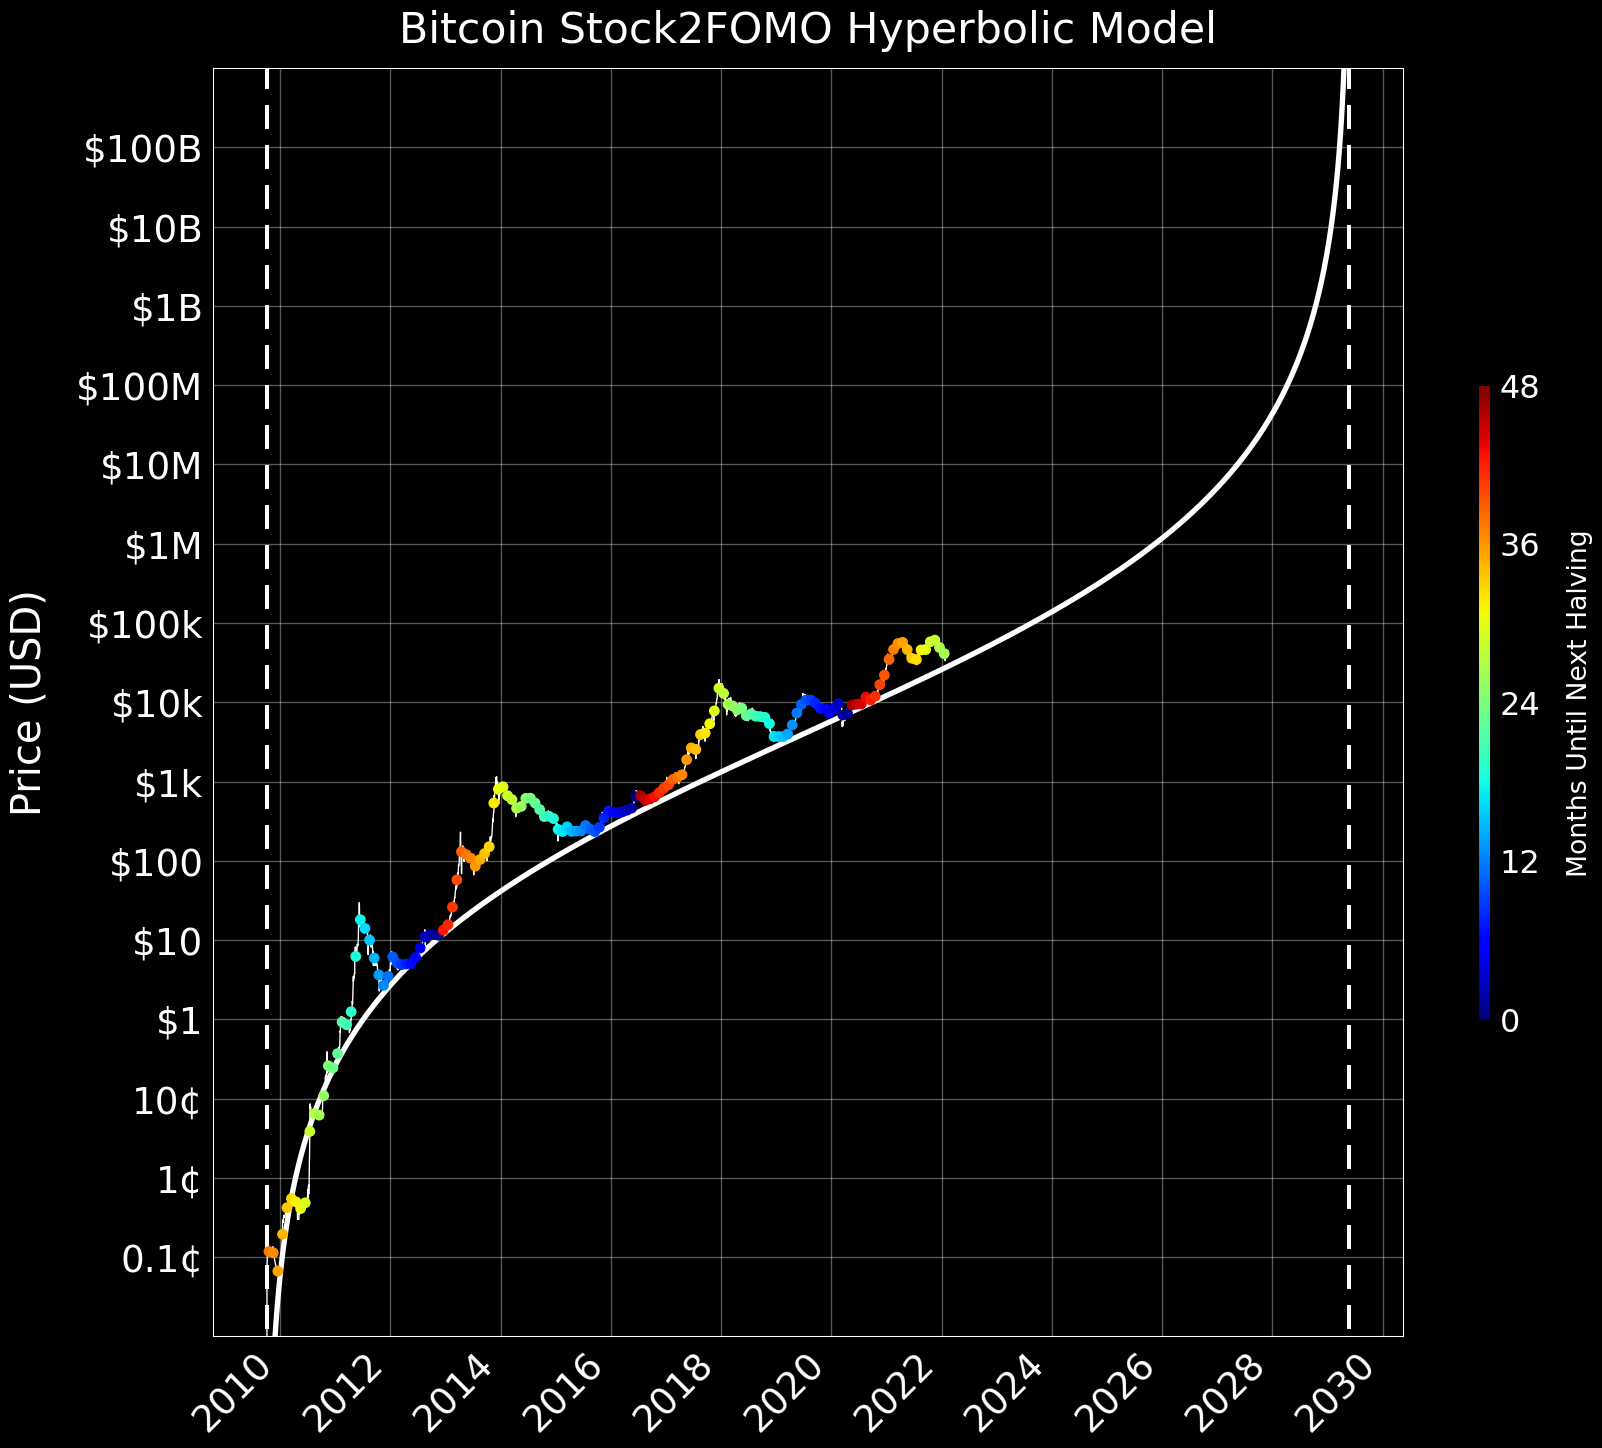

In [13]:
stock2fomochart([18106], [8.35], [3.59], [1/3584.], s2f_alpha=1)

In [14]:
# stock2fomochart_v2([3584], [4230.18], [3.59], s2f_alpha=1)

<Figure size 432x288 with 0 Axes>

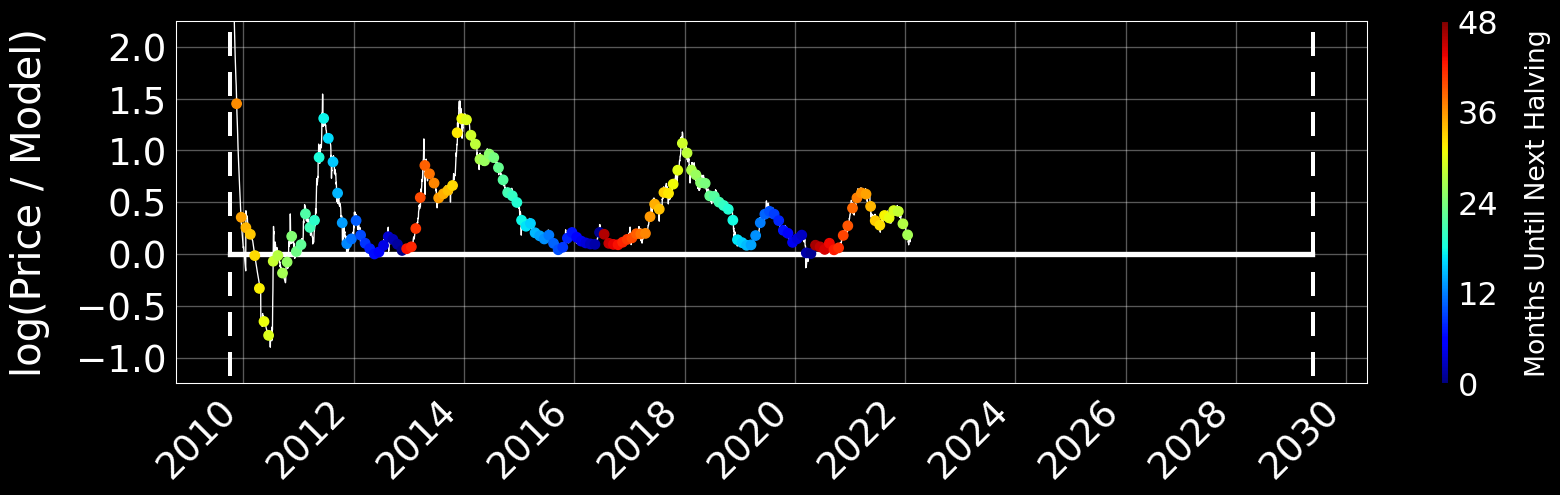

In [15]:
stock2fomochart_res(18106, 8.35, 3.59, 1/3584.)